In [1]:
import numpy as np
np.random.seed(1000)
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import math
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from numpy import dot
import datetime
import plotly.graph_objects as go
import yfinance as yf
import scipy

In [2]:
#!pip3 install plotly

In [3]:
Sp=yf.download("^GSPC",start="2010-06-22")
#Sp=yf.download("AMZN")#,start="2010-06-22")

[*********************100%***********************]  1 of 1 completed


In [4]:
data=Sp["Adj Close"]

### Calculates Forwards simulates Geometric Brownian Motion of spot price and Forward price

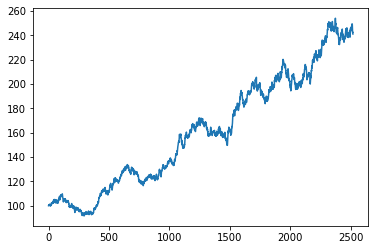

In [5]:
TimeDelta=1/252        #assume daily prices but could add as an input to function
mu=0.1                 #percentage drift(the rate at which avarages change)
Dsig=0.1            # annualized volatility(extrapolating the volatility over a year)
Szero=100          #Initial price
Steps=10*252       #Time in years
TimeLength=TimeDelta*Steps   #lenght of time
time=np.linspace(0,TimeLength,Steps)
sigma=Dsig*np.sqrt(TimeDelta)*np.random.randn(Steps)   #vector of random movements
alphadt=(mu-0.5*Dsig**2)*TimeDelta
S=np.zeros(Steps)
S[0]=Szero
for i in range(1,Steps):
    S[i]=S[i-1]*np.exp(alphadt+sigma[i])      #Computes the spot price
plt.plot(range(Steps),S)

Text(0, 0.5, 'PRICE')

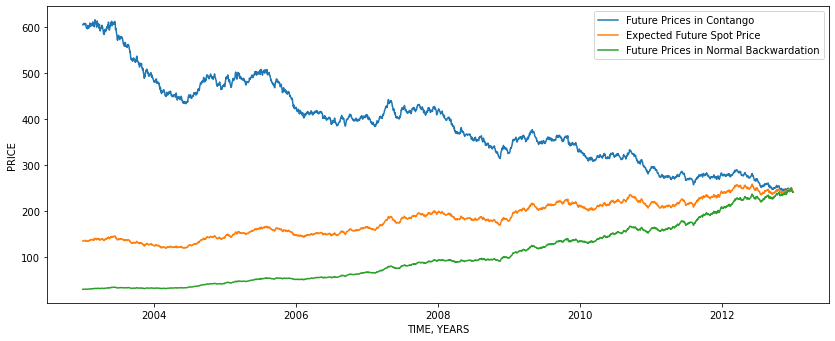

In [6]:
#logarithmic returns log(St/S0) is normally distributed
LogDelta=np.log(S[1:])-np.log(S[0:-1])
StanDev=np.std(LogDelta)

EstVol=StanDev/np.sqrt(TimeDelta)

#Estimate annualized volotility
EstMu=np.mean(LogDelta)/TimeDelta+(EstVol**2)/2   #log increments of GBM are normal relative to price t

Expected=np.zeros(Steps)
SD=np.zeros(Steps)
Expected = S[0]*np.exp((EstMu)*(time))     #Expected sport price    E[S_t]=S_0e^mu*t

time2003=time+2003                         #starting from year 2003
ExpectedLine=Expected[-1]*np.ones(Steps)

r=0.03                                   #risk-free rate
u=0.2                                    #cost of storage
y1=0.05; y2=0.2; y3=0.35                 #convenience yields
tau=time[-1]-time;                     #small time changes
#Forward prices
Ftau1=S*np.exp(tau*(r+u-y1))
Ftau2=S*np.exp(tau*(r+u-y2))
Ftau3=S*np.exp(tau*(r+u-y3))



#plot
plt.figure(figsize=(14,12))
#plt.subplot(2,1,1)
#plt.plot(time2003,S)
#plt.plot(time2003,Expected)
#plt.plot(time2003,ExpectedLine,"-.")

plt.subplot(2,1,2)
plt.plot(time2003, Ftau1,time2003, Ftau2,time2003, Ftau3)
plt.legend(["Future Prices in Contango","Expected Future Spot Price","Future Prices in Normal Backwardation"])
plt.xlabel("TIME, YEARS")
plt.ylabel("PRICE")
#plt.plot(tau, Ftau3)

In [7]:
#parameters
kappa=0.04;sigma=0.1;alpha_star=0.43;alpha=11.6;

### We define the function $\alpha^{*}(1-e^{-\kappa\times \tau})+\frac{\sigma^{2}}{4\times \kappa}(1-e^{-2\kappa\times \tau})$

In [8]:
def d_tau(tau):
    global alpha_star,kappa,sigma
    return alpha_star*(1-np.exp(-kappa*tau))+(sigma**2/(4*kappa)-(1-np.exp(-2*kappa*tau)))

### We define the function $\ln S_{t}=e^{-\kappa\times \tau}\ln S_{t-1}+\alpha(1-e^{-\kappa\times \tau})$

In [9]:
def LnS(S0):
    global t,kappa,alpha
    LnS=np.zeros(len(t))
    LnS[0]=np.log(S0)
    for i in range(1,len(t)):
        LnS[i]=np.exp(-kappa*t[i])*LnS[i-1]+alpha*(1-np.exp(-kappa*t[i]))

    return LnS

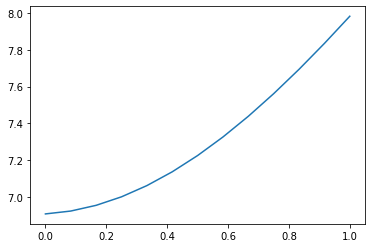

In [10]:
t=np.arange(0,1.01,1/12)
S0=1000
plt.plot(t,LnS(S0))

### We define the function $\ln F=e^{-\kappa\times \tau} \ln S_{\tau}+\alpha^{*}(1-e^{-\kappa\times \tau})+\frac{\sigma^{2}}{4\times \kappa}(1-e^{-2\kappa\times \tau})$

$S_\tau$ is the actual price and $\tau_{1,2,3,4}$ is for 1,2,3,4-month future.

In [11]:
def one_factor_kalman():
    global data, alpha_star,kappa,sigma
    timeMat=np.array([1,2,3,4])/12 #1,2,3,4 month future for tau_1, tau_2, tau_3 and tau_4
    #TimeDelta=1/12
    F=[]#matrix of the future price
    for tau in timeMat:#take a tau
        #Compute each row
        FF=np.array(np.exp(-kappa*tau)*np.log(data)+d_tau(tau))#tau,alpha_star,kappa,sigma))#appying the formula
        
        #append it to our matrix
        F.append(FF)
    return F

Text(0, 0.5, 'Future Prices')

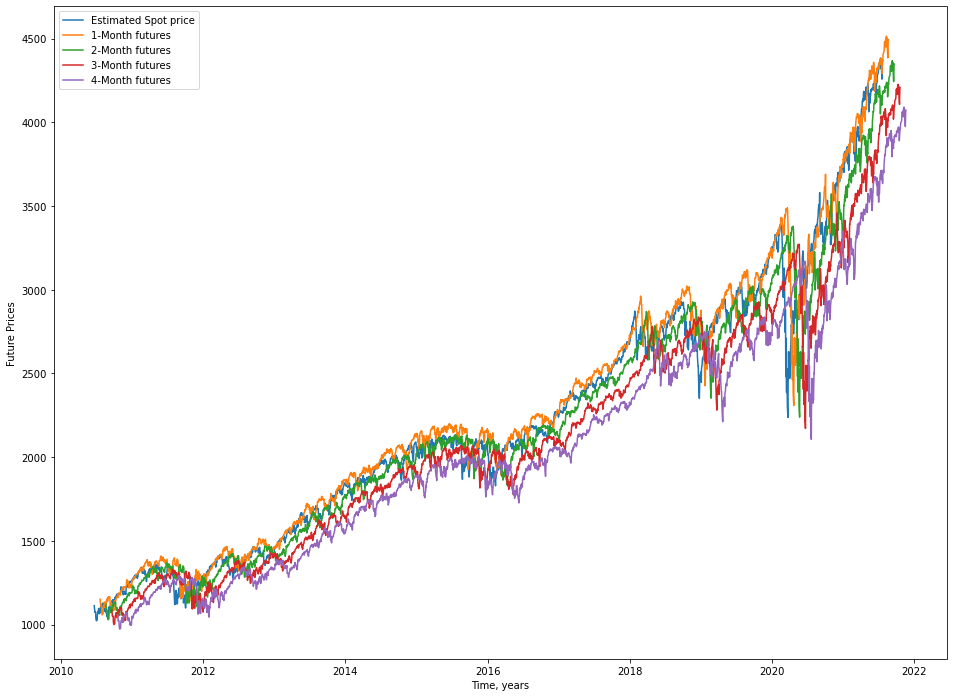

In [12]:

#one_factor_kalman(alpha_star,kappa,sigma)

#take the future price
Future=one_factor_kalman()#alpha_star,kappa,sigma

#take the exponential

#we use series to associate the price with the date
Month1=pd.Series(np.exp(Future[0]),index=data.index+datetime.timedelta(days=30*1))
Month2=pd.Series(np.exp(Future[1]),index=data.index+datetime.timedelta(days=30*2))
Month3=pd.Series(np.exp(Future[2]),index=data.index+datetime.timedelta(days=30*3))
Month4=pd.Series(np.exp(Future[3]),index=data.index+datetime.timedelta(days=30*4))
#plot future prices  vs time
plt.figure(figsize=(16, 12))
plt.plot(data.index,data,Month1.index,Month1,Month2.index,Month2,Month3.index,Month3,Month4.index,Month4)

plt.legend(["Estimated Spot price","1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Future Prices")

In [13]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Estimated Spot price' , 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, [round(data[dt][0],3) for dt in date_list],
                                   [round(Month1[dt][0],2) for dt in date_list],[round(Month2[dt][0],2) for dt in date_list],
                                   [round(Month3[dt][0],2) for dt in date_list],[round(Month4[dt][0],2) for dt in date_list]]))
                     ])
fig.show()

### Kalman measurement error( Predicted futures price -  Observed futures price)

## normal prices

In [14]:
def Error1():
    global data,Month1,Month2,Month3,Month4
    #Month1
    ide1=[]#set of index
    Err1=[]#the error
    for dt in data.index:
        if dt in Month1.index:#date in the intersection
            ide1.append(dt)
            Err1.append(Month1[dt]-data[dt])#compute the error  (Predicted futures price - observed futures price)
            
    #make it as a series
    MesErr1=pd.Series(Err1,ide1)
            
    #Month2
    ide2=[]
    Err2=[]
    for dt in data.index:
        if dt in Month2.index:
            ide2.append(dt)
            Err2.append(Month2[dt]-data[dt])
    MesErr2=pd.Series(Err2,ide2)   
    
    #Month3
    ide3=[]
    Err3=[]
    for dt in data.index:
        if dt in Month3.index:
            ide3.append(dt)
            Err3.append(Month3[dt]-data[dt])
    MesErr3=pd.Series(Err3,ide3)
    
    #month 4
    ide4=[]
    Err4=[]
    for dt in data.index:
        if dt in Month4.index:
            ide4.append(dt)
            Err4.append(Month4[dt]-data[dt])
    MesErr4=pd.Series(Err4,ide4)
    
    return MesErr1,MesErr2,MesErr3,MesErr4

Text(0, 0.5, 'Measurement Error')

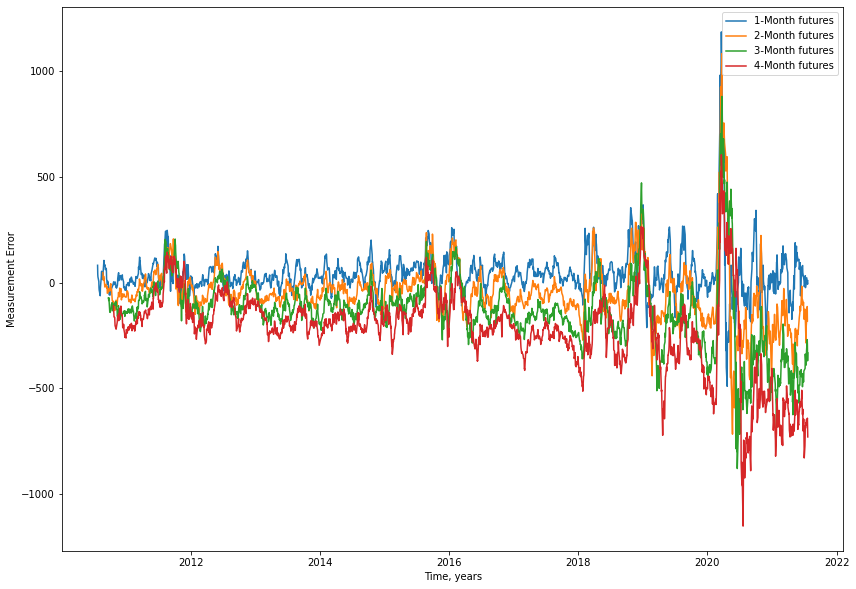

In [15]:
MesErr1,MesErr2,MesErr3,MesErr4=Error1()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")


## ERROR TABLE MONTHS-ESTIMATED SPOT FOR $2011$(NORMAL PRICES).

In [16]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, #[round(data[dt][0],3) for dt in date_list],
                                   [round(Month1[dt][0]-data[dt][0],3) for dt in date_list],[round(Month2[dt][0]-data[dt][0],3) for dt in date_list],
                                   [round(Month3[dt][0]-data[dt][0],3) for dt in date_list],[round(Month4[dt][0]-data[dt][0],3) for dt in date_list]]))
                     ])
fig.show()

## ERROR TABLE FOR ESTIMATED SPOT-MONTHS FOR $2011$(NORMAL PRICES).

In [17]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, #[round(data[dt][0],3) for dt in date_list],
                                   [round(data[dt][0]-Month1[dt][0],2) for dt in date_list],[round(data[dt][0]-Month2[dt][0],2) for dt in date_list],
                                   [round(data[dt][0]-Month3[dt][0],2) for dt in date_list],[round(data[dt][0]-Month4[dt][0],2) for dt in date_list]]))
                     ])
fig.show()

In [18]:
#date_list=['2020-{}'.format(i) for i in range(1,13)]


#fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
 #                cells=dict(values=[date_list, 
  #                                 [round(MesErr1[dt][0],3) for dt in date_list],[round(MesErr2[dt][0],3) for dt in date_list],
   #                                [round(MesErr3[dt][0],3) for dt in date_list],[round(MesErr4[dt][0],3) for dt in date_list]]))
                   #  ])
#fig.show()

## Error in log prices

In [19]:
def Error2():
    global data,Month1,Month2,Month3,Month4
    #Month1
    ide1=[]#set of index
    Err1=[]#the error
    for dt in data.index:
        if dt in Month1.index:#date in the intersection
            ide1.append(dt)
            Err1.append(np.log(Month1[dt])-np.log(data[dt]))#compute the error  (Predicted futures price - observed futures price)
            
    #make it as a series
    MesErr1=pd.Series(Err1,ide1)
            
    #Month2
    ide2=[]
    Err2=[]
    for dt in data.index:
        if dt in Month2.index:
            ide2.append(dt)
            Err2.append(np.log(Month2[dt])-np.log(data[dt]))
    MesErr2=pd.Series(Err2,ide2)   
    
    #Month3
    ide3=[]
    Err3=[]
    for dt in data.index:
        if dt in Month3.index:
            ide3.append(dt)
            Err3.append(np.log(Month3[dt])-np.log(data[dt]))
    MesErr3=pd.Series(Err3,ide3)
    
    #month 4
    ide4=[]
    Err4=[]
    for dt in data.index:
        if dt in Month4.index:
            ide4.append(dt)
            Err4.append(np.log(Month4[dt])-np.log(data[dt]))
    MesErr4=pd.Series(Err4,ide4)
    
    return MesErr1,MesErr2,MesErr3,MesErr4

Text(0, 0.5, 'Measurement Error')

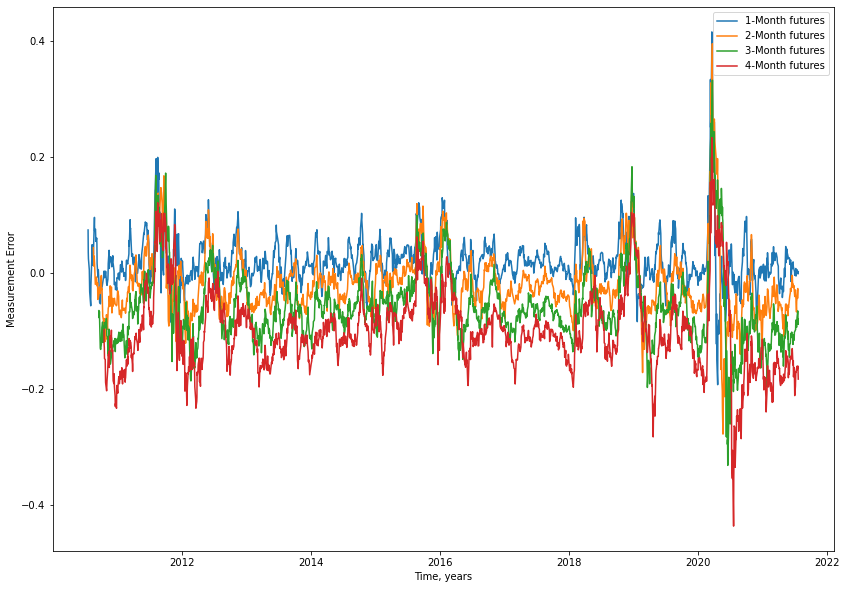

In [20]:
MesErr1,MesErr2,MesErr3,MesErr4=Error2()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

## ERROR TABLE MONTHS-ESTIMATED SPOT FOR $2020$(LOG PRICES).

In [21]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig2_old_param = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, 
                                   [round(MesErr1[dt][0],3) for dt in date_list],[round(MesErr2[dt][0],3) for dt in date_list],
                                   [round(MesErr3[dt][0],3) for dt in date_list],[round(MesErr4[dt][0],3) for dt in date_list]]))
                     ])
fig2_old_param.show()

### Kalman measurement error(  Observed futures price-Predicted futures price )

##  log prices

In [22]:
def Error3():
    global data,Month1,Month2,Month3,Month4
    #Month1 #We want the common date
    ide1=[]#set of index (common date)
    Err1=[]#the error
    for dt in data.index:#the indices of the data are date
        if dt in Month1.index:#date in the intersection #for the same date, we can compare it if we have it in both
            ide1.append(dt)
            Err1.append(np.log(data[dt])-np.log(Month1[dt]))#compute the error  (observed futures price-Predicted futures price)
            
    #make it as a series
    MesErr1=pd.Series(Err1,ide1)
            
    #Month2
    ide2=[]
    Err2=[]
    for dt in data.index:
        if dt in Month2.index:
            ide2.append(dt)
            Err2.append(np.log(data[dt])-np.log(Month2[dt]))
    MesErr2=pd.Series(Err2,ide2)   
    
    #Month3
    ide3=[]
    Err3=[]
    for dt in data.index:
        if dt in Month3.index:
            ide3.append(dt)
            Err3.append(np.log(data[dt])-np.log(Month3[dt]))
    MesErr3=pd.Series(Err3,ide3)
    
    #month 4
    ide4=[]
    Err4=[]
    for dt in data.index:
        if dt in Month4.index:
            ide4.append(dt)
            Err4.append(np.log(data[dt])-np.log(Month4[dt]))
    MesErr4=pd.Series(Err4,ide4)
    
    return MesErr1,MesErr2,MesErr3,MesErr4

Text(0, 0.5, 'Measurement Error')

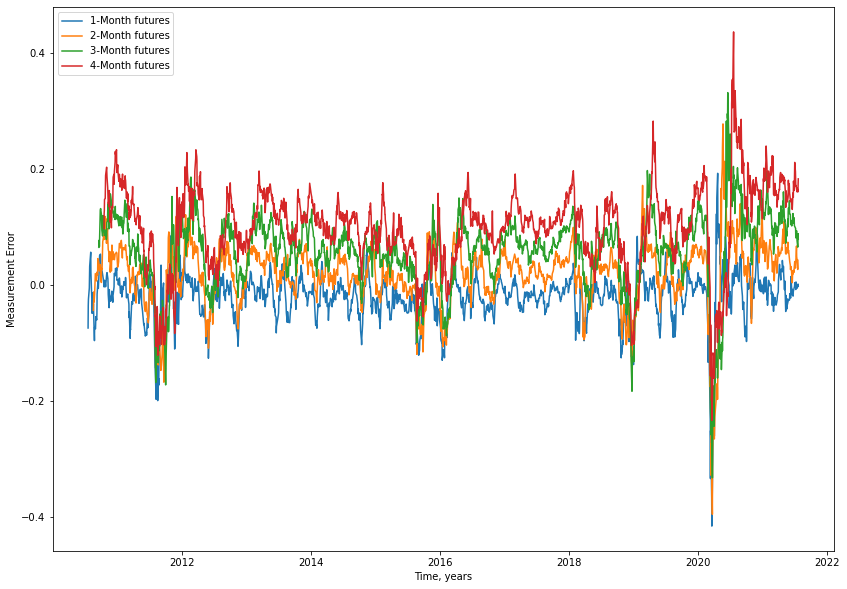

In [23]:
MesErr1,MesErr2,MesErr3,MesErr4=Error3()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

In [24]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, 
                                   [round(MesErr1[dt][0],3) for dt in date_list],[round(MesErr2[dt][0],3) for dt in date_list],
                                   [round(MesErr3[dt][0],3) for dt in date_list],[round(MesErr4[dt][0],3) for dt in date_list]]))
                     ])
fig.show()

### We plot the  Kalman measurement error( Observed futures price-Predicted futures price)

## normal prices

In [25]:
def Error4():
    global data,Month1,Month2,Month3,Month4
    #Month1
    ide1=[]#set of index
    Err1=[]#the error
    for dt in data.index:
        if dt in Month1.index:#date in the intersection
            ide1.append(dt)
            Err1.append(data[dt]-Month1[dt])#compute the error  (observed futures price-Predicted futures price)
            
    #make it as a series
    MesErr1=pd.Series(Err1,ide1)
            
    #Month2
    ide2=[]
    Err2=[]
    for dt in data.index:
        if dt in Month2.index:
            ide2.append(dt)
            Err2.append(data[dt]-Month2[dt])
    MesErr2=pd.Series(Err2,ide2)   
    
    #Month3
    ide3=[]
    Err3=[]
    for dt in data.index:
        if dt in Month3.index:
            ide3.append(dt)
            Err3.append(data[dt]-Month3[dt])
    MesErr3=pd.Series(Err3,ide3)
    
    #month 4
    ide4=[]
    Err4=[]
    for dt in data.index:
        if dt in Month4.index:
            ide4.append(dt)
            Err4.append(data[dt]-Month4[dt])
    MesErr4=pd.Series(Err4,ide4)
    
    return MesErr1,MesErr2,MesErr3,MesErr4

Text(0, 0.5, 'Measurement Error')

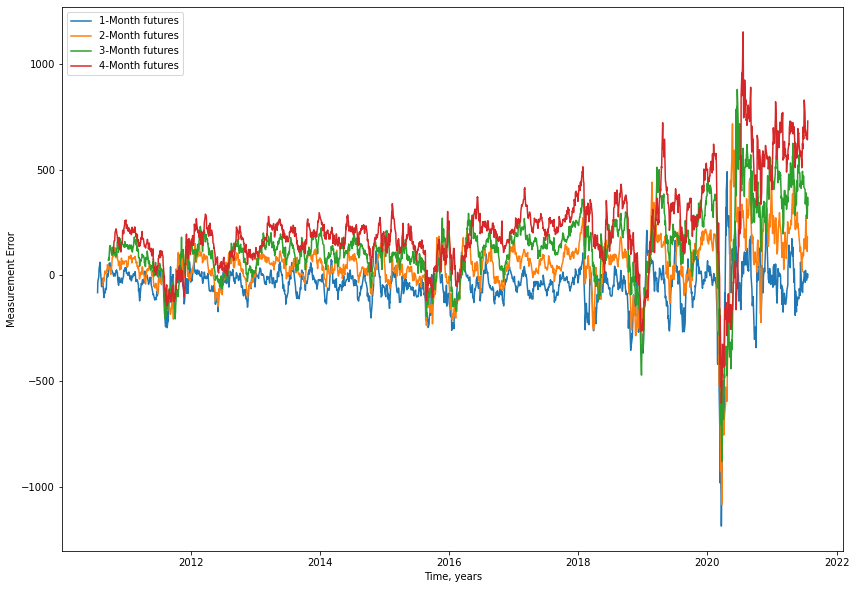

In [26]:
MesErr1,MesErr2,MesErr3,MesErr4=Error4()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

In [27]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, 
                                   [round(MesErr1[dt][0],3) for dt in date_list],[round(MesErr2[dt][0],3) for dt in date_list],
                                   [round(MesErr3[dt][0],3) for dt in date_list],[round(MesErr4[dt][0],3) for dt in date_list]]))
                     ])
fig.show()

## Starting from here we will get the optimal parameters by optimization

In [28]:
def Error1_sum(parameter):
    global kappa, sigma, alpha_star, alpha
    global Month1,Month2,Month3,Month4 #global because of the function Error1()
    kappa=parameter[0]
    sigma=parameter[1]
    alpha_star=parameter[2]
    alpha=parameter[3]
    
    #take the future price
    Future=one_factor_kalman()#alpha_star,kappa,sigma)

    #take the exponential
    Month1=pd.Series(np.exp(Future[0]),index=data.index+datetime.timedelta(days=30*1))
    Month2=pd.Series(np.exp(Future[1]),index=data.index+datetime.timedelta(days=30*2))
    Month3=pd.Series(np.exp(Future[2]),index=data.index+datetime.timedelta(days=30*3))
    Month4=pd.Series(np.exp(Future[3]),index=data.index+datetime.timedelta(days=30*4))
    
    MesErr1,MesErr2,MesErr3,MesErr4=Error1()
    
    #Avoiding Negative parameter
    Neg=0
    for p in parameter:
        if p<=0:
            Neg=Neg+100000
            
    #Metric squared error
    return sum((MesErr1)**2)+sum((MesErr2)**2)+sum((MesErr3)**2)+sum((MesErr4)**2)+Neg
    

In [29]:
paramguess=[0.04,0.1,0.43,11.6]
#the following function try to find the parameter which minimize the Error1_sum function
pnew=scipy.optimize.fmin(Error1_sum,paramguess)
pnew

array([1.24108816e-06, 3.80559024e-04, 1.04130553e+00, 1.65202760e+01])

In [30]:
kappa=pnew[0]
sigma=pnew[1]
alpha_star=pnew[2]
alpha=pnew[3]

Text(0, 0.5, 'Future Prices')

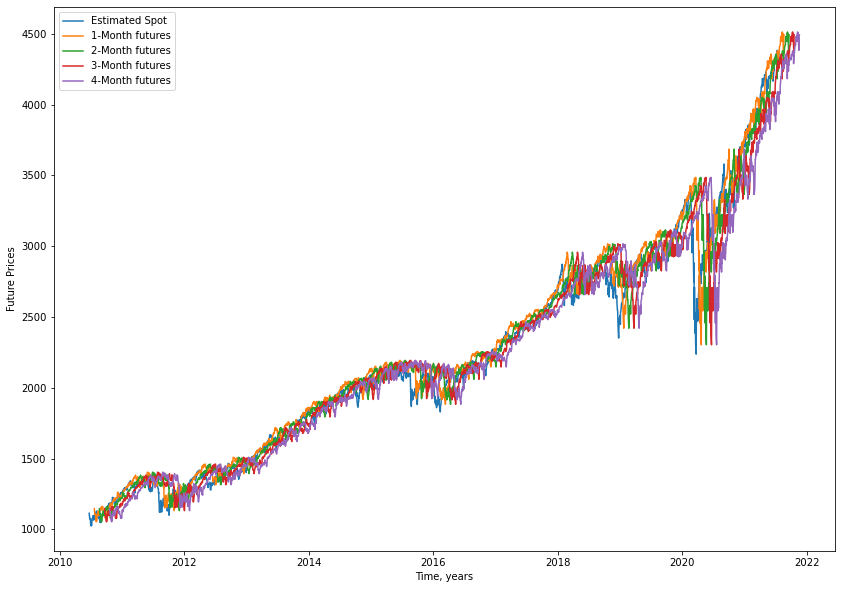

In [31]:
#one_factor_kalman(alpha_star,kappa,sigma)

#take the future price
Future=one_factor_kalman()#alpha_star,kappa,sigma

#take the exponential

#we use series to associate the price with the date
Month1=pd.Series(np.exp(Future[0]),index=data.index+datetime.timedelta(days=30*1))
Month2=pd.Series(np.exp(Future[1]),index=data.index+datetime.timedelta(days=30*2))
Month3=pd.Series(np.exp(Future[2]),index=data.index+datetime.timedelta(days=30*3))
Month4=pd.Series(np.exp(Future[3]),index=data.index+datetime.timedelta(days=30*4))
#plot future prices  vs time
plt.figure(figsize=(14, 10))
plt.plot(data.index,data,Month1.index,Month1,Month2.index,Month2,Month3.index,Month3,Month4.index,Month4)

plt.legend(["Estimated Spot","1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Future Prices")

## TABLE WITH ESTIMATED SPOT AND FUTURES FOR THE YEAR 2020.

In [48]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Estimated Spot price' , 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, [round(data[dt][0],3) for dt in date_list],
                                   [round(Month1[dt][0],2) for dt in date_list],[round(Month2[dt][0],2) for dt in date_list],
                                   [round(Month3[dt][0],2) for dt in date_list],[round(Month4[dt][0],2) for dt in date_list]]))
                     ])
fig.show()

## MONTHS(PREDICTED)-SPOT PRICE(ESTIMATED).-------ERROR-----NORMAL PRICES

In [33]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, #[round(data[dt][0],3) for dt in date_list],
                                   [round(Month1[dt][0]-data[dt][0],3) for dt in date_list],[round(Month2[dt][0]-data[dt][0],3) for dt in date_list],
                                   [round(Month3[dt][0]-data[dt][0],3) for dt in date_list],[round(Month4[dt][0]-data[dt][0],3) for dt in date_list]]))
                     ])
fig.show()

## SPOT PRICE(ESTIMATED)-MONTHS(PREDICTED).-------ERROR-------NORMAL PRICES

In [34]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, #[round(data[dt][0],3) for dt in date_list],
                                   [round(data[dt][0]-Month1[dt][0],3) for dt in date_list],[round(data[dt][0]-Month2[dt][0],3) for dt in date_list],
                                   [round(data[dt][0]-Month3[dt][0],3) for dt in date_list],[round(data[dt][0]-Month4[dt][0],3) for dt in date_list]]))
                     ])
fig.show()

## PLOT FOR ERRORS WITH NEW PARAMETERS AND NORMAL PRICES.


## MONTHS-ESTIMATED PRICE----ERROR$1$.

Text(0, 0.5, 'Measurement Error')

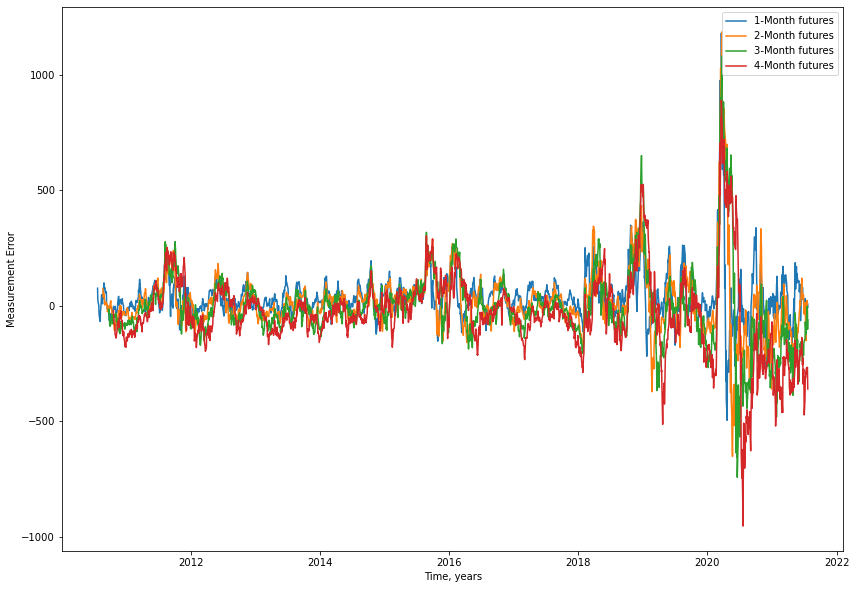

In [35]:
MesErr1,MesErr2,MesErr3,MesErr4=Error1()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

In [36]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, #[round(data[dt][0],3) for dt in date_list],
                                   [round(Month1[dt][0]-data[dt][0],3) for dt in date_list],[round(Month2[dt][0]-data[dt][0],3) for dt in date_list],
                                   [round(Month3[dt][0]-data[dt][0],3) for dt in date_list],[round(Month4[dt][0]-data[dt][0],3) for dt in date_list]]))
                     ])
fig.show()

In [37]:
#date_list=['2020-{}'.format(i) for i in range(1,13)]


#fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
 #                cells=dict(values=[date_list, 
  #                                 [round(MesErr1[dt][0],3) for dt in date_list],[round(MesErr2[dt][0],3) for dt in date_list],
   #                                [round(MesErr3[dt][0],3) for dt in date_list],[round(MesErr4[dt][0],3) for dt in date_list]]))
    #                 ])
#fig.show()

In [38]:
#Month1["2020"]

## PLOT FOR ERRORS WITH NEW PARAMETERS AND LOG PRICES.


## MONTHS-ESTIMATED PRICE------ERROR$2$.

Text(0, 0.5, 'Measurement Error')

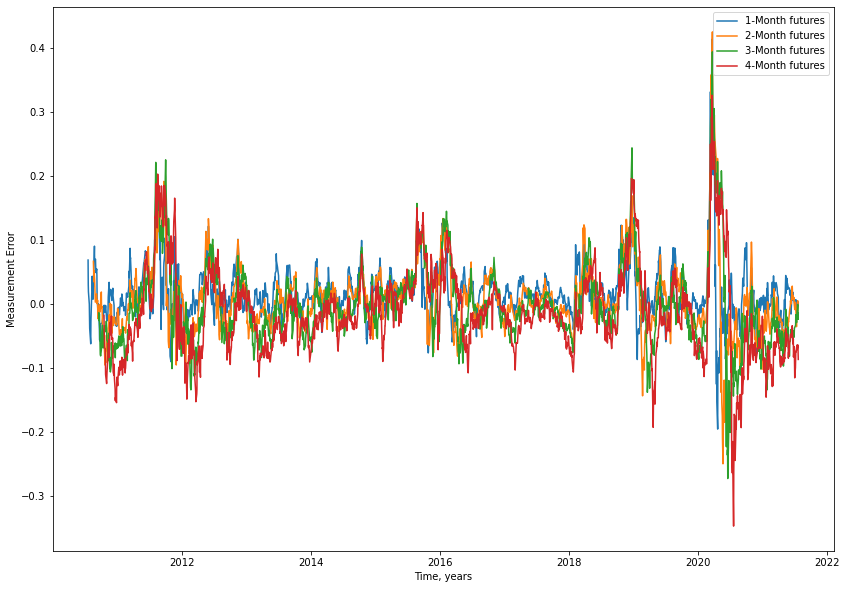

In [39]:
MesErr1,MesErr2,MesErr3,MesErr4=Error2()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

In [40]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, 
                                   [round(np.log(Month1[dt][0])-np.log(data[dt][0]),4) for dt in date_list],[round(np.log(Month2[dt][0])-np.log(data[dt][0]),4) for dt in date_list],
                                   [round(np.log(Month3[dt][0])-np.log(data[dt][0]),4) for dt in date_list],[round(np.log(Month4[dt][0])-np.log(data[dt][0]),4) for dt in date_list]]))
                     ])
fig.show()

## PLOT FOR ERRORS WITH NEW PARAMETERS AND LOG PRICES.


## MONTHS-ESTIMATED PRICE------ERROR$3$.

Text(0, 0.5, 'Measurement Error')

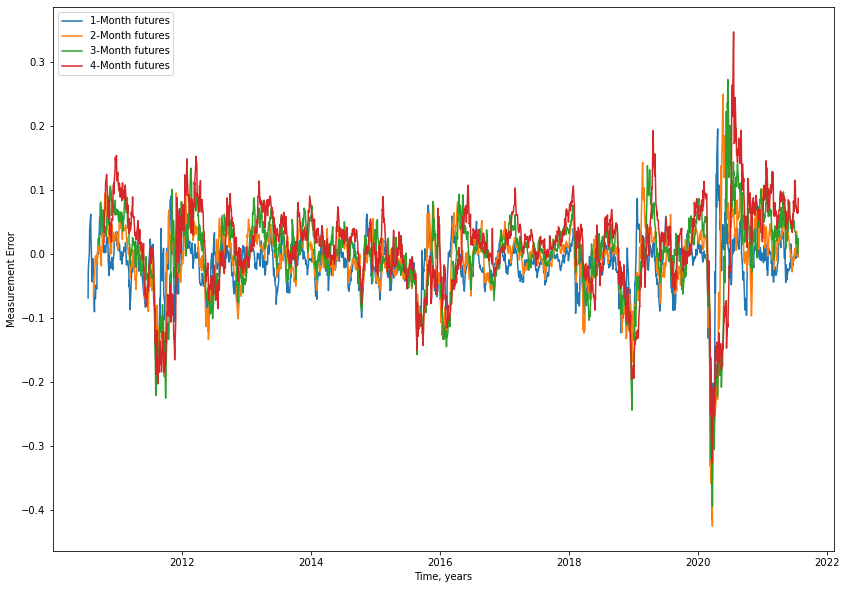

In [41]:
MesErr1,MesErr2,MesErr3,MesErr4=Error3()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

In [42]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, 
                                   [round(np.log(data[dt][0])-np.log(Month1[dt][0]),4) for dt in date_list],[round(np.log(data[dt][0])-np.log(Month2[dt][0]),4) for dt in date_list],
                                   [round(np.log(data[dt][0])-np.log(Month3[dt][0]),4) for dt in date_list],[round(np.log(data[dt][0])-np.log(Month4[dt][0]),4) for dt in date_list]]))
                     ])
fig.show()

## PLOT FOR ERRORS WITH NEW PARAMETERS AND NORMAL PRICES.


## MONTHS-ESTIMATED PRICE------ERROR$4$.

Text(0, 0.5, 'Measurement Error')

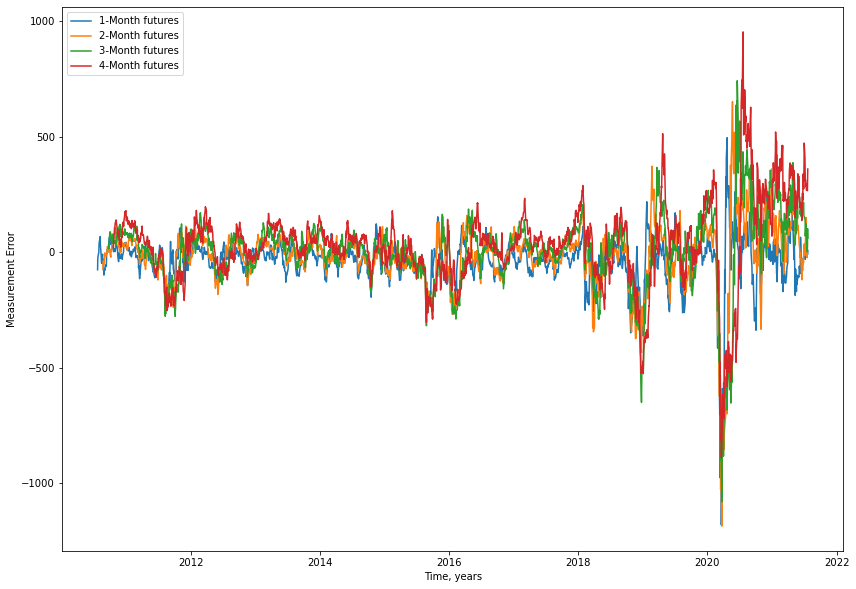

In [43]:
MesErr1,MesErr2,MesErr3,MesErr4=Error4()
plt.figure(figsize=(14,10))
plt.plot(MesErr1.index,MesErr1,MesErr2.index,MesErr2,MesErr3.index,MesErr3,MesErr4.index,MesErr4)
plt.legend(["1-Month futures","2-Month futures","3-Month futures","4-Month futures"])
plt.xlabel("Time, years")
plt.ylabel("Measurement Error")

In [44]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, #[round(data[dt][0],3) for dt in date_list],
                                   [round(data[dt][0]-Month1[dt][0],3) for dt in date_list],[round(data[dt][0]-Month2[dt][0],3)  for dt in date_list],
                                   [round(data[dt][0]-Month3[dt][0],3)  for dt in date_list],[round(data[dt][0]-Month4[dt][0],3)  for dt in date_list]]))
                     ])
fig.show()

In [45]:
#date_list=['2020-{}'.format(i) for i in range(1,13)]
#

#fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
 #                cells=dict(values=[date_list, 
  #                                 [round(MesErr1[dt][0],3) for dt in date_list],[round(MesErr2[dt][0],3) for dt in date_list],
   #                                [round(MesErr3[dt][0],3) for dt in date_list],[round(MesErr4[dt][0],3) for dt in date_list]]))
    #                 ])
#fig.show()

In [46]:
#fig2_old_param.show()

In [47]:
date_list=['2015-{}'.format(i) for i in range(1,13)]


fig = go.Figure([go.Table(header=dict(values=['Date', 'Month 1' , 'Month 2' ,'Month 3', 'Month 4']),
                 cells=dict(values=[date_list, 
                                   [round(np.log(Month1[dt][0])-np.log(data[dt][0]),4) for dt in date_list],[round(np.log(Month2[dt][0])-np.log(data[dt][0]),4) for dt in date_list],
                                   [round(np.log(Month3[dt][0])-np.log(data[dt][0]),4) for dt in date_list],[round(np.log(Month4[dt][0])-np.log(data[dt][0]),4) for dt in date_list]]))
                     ])
fig.show()